In [1]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time
from astropy.coordinates import HeliocentricMeanEcliptic, HeliocentricTrueEcliptic, SkyCoord

from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body

import sunpy.coordinates

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic
import scipy.signal 

import time
import copy

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
EITmetadata = Table.read("./EIT/EITresults/EIT_headerMetadata.txt",format="ascii.basic")
print(np.shape(EITmetadata))
#print(EITmetadata)
print(EITmetadata.colnames)

(91883,)
['DATE-BEG', 'DATE-AVG', 'XPOSURE', 'CMDXPOS', 'SHUTCLS', 'FILTER', 'WAVELNTH', 'OBJECT', 'SCI_OBJ', 'OBS_PROG', 'CMP_NO', 'UCD', 'EXPMODE', 'LYNESYNC', 'ROUTPORT', 'NLEBPROC', 'LEBPROC1', 'LEBPROC2', 'LEBPROC3', 'WCSNAME', 'CTYPE1', 'CTYPE2', 'CUNIT1', 'CUNIT2', 'PC1_1', 'PC1_2', 'PC2_1', 'PC2_2', 'CDELT1', 'CDELT2', 'CRVAL1', 'CRVAL2', 'CRPIX1', 'CRPIX2', 'CROTA', 'CFTEMP', 'CCDTEMP', 'SOLAR_B0', 'RSUN_ARC', 'RSUN_OBS', 'RSUN_REF', 'CAR_ROT', 'DSUN_OBS', 'SC_X0', 'SC_Y0', 'SC_ROLL', 'HAEX_OBS', 'HAEY_OBS', 'HAEZ_OBS', 'HI-LAT-DEG', 'HI-LON-DEG']


In [3]:
print(2//3)
print(8//2)
print(9//2)
print(9%2)

print(6.14%3.14)

0
4
4
1
2.9999999999999996


In [4]:
print(np.min(EITmetadata['CROTA']))
print(np.max(EITmetadata['CROTA']))
print(np.min((EITmetadata['CROTA']+360)%180))
print(np.max((EITmetadata['CROTA']+360)%180))

crota_sign = copy.deepcopy(np.array(EITmetadata['CROTA']))
crota_sign[crota_sign < -90] = crota_sign[crota_sign < -90] + 180
crota_sign[crota_sign > 90] = crota_sign[crota_sign > 90] - 180
                

-288.0
179.99
0.0
179.99000000022352


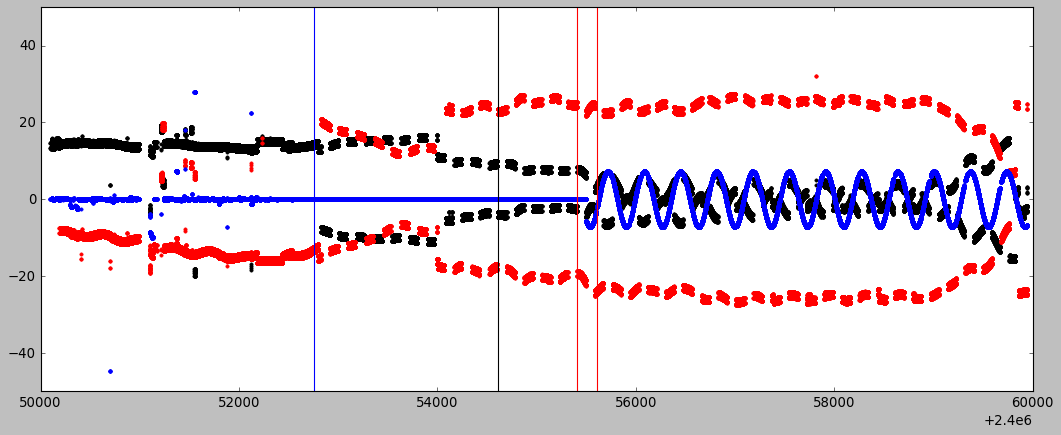

In [5]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot(EITmetadata['DATE-BEG'], EITmetadata['CRVAL1'],'k.')
ax.plot(EITmetadata['DATE-BEG'], EITmetadata['CRVAL2'],'r.')
ax.plot(EITmetadata['DATE-BEG'], crota_sign,'b.')
#ax.plot(EITmetadata['DATE-BEG'], 180%(EITmetadata['CROTA']+360) -180,'r.')
ax.set_ylim(-50,50)
ax.axvline(2452761.162303, color='b') #May 1 2003, near when high gain antenna started showing problems
ax.axvline(2454609, color='k')
ax.axvline(2455406.162303, color='r') #end of bakeout July 28 2010
ax.axvline(2455609.162303, color='r') #end of bakeout 16 Feb 2011
#ax.set_xlim(2455000,2456000)
plt.show()

In [6]:
dcalc = np.sqrt(EITmetadata['HAEX_OBS']**2 + EITmetadata['HAEY_OBS']**2 + EITmetadata['HAEZ_OBS']**2)


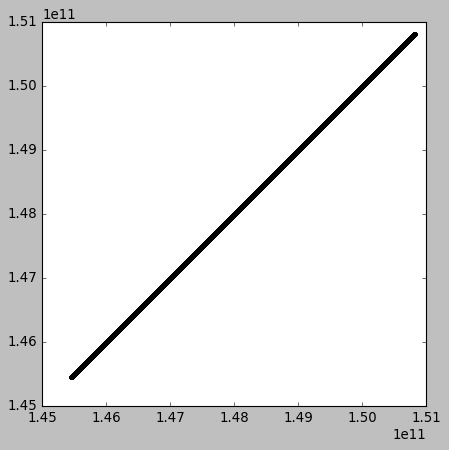

In [7]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(EITmetadata['DSUN_OBS'], dcalc, 'k.')
ax.set_aspect("equal")
plt.show()

In [8]:
for i in range(1):
    HAEcoords = SkyCoord(frame='heliocentricmeanecliptic',
                         x=EITmetadata['HAEX_OBS'][i]*u.m, 
                         y=EITmetadata['HAEY_OBS'][i]*u.m,
                         z=EITmetadata['HAEZ_OBS'][i]*u.m, 
                         representation_type='cartesian',
                         obstime=astropy.time.Time(EITmetadata['DATE-AVG'][i],format='jd'),
                         equinox=astropy.time.Time(EITmetadata['DATE-AVG'][i],format='jd'))
                         #equinox='J2000')
    print(HAEcoords)
    HIcoords = HAEcoords.transform_to(sunpy.coordinates.frames.HeliocentricInertial())
    print(HIcoords)
    HTEcoords = HAEcoords.transform_to(HeliocentricTrueEcliptic(equinox=astropy.time.Time(EITmetadata['DATE-AVG'][i],format='jd')))
    print(HTEcoords)



<SkyCoord (HeliocentricMeanEcliptic: equinox=2450098.536677118, obstime=2450098.536677118): (x, y, z) in m
    (-6.4908808e+10, 1.30562576e+11, -77407740.)>
<SkyCoord (HeliocentricInertial: obstime=2450098.536677118): (lon, lat, distance) in (deg, deg, m)
    (40.49344787, -4.75368571, 1.45807221e+11)>
<SkyCoord (HeliocentricTrueEcliptic: equinox=2450098.536677118, obstime=2450098.536677118): (lon, lat, distance) in (deg, deg, m)
    (116.43616581, -0.03041781, 1.45807221e+11)>


In [9]:
HAEcoords = SkyCoord(frame='heliocentricmeanecliptic',
                     x=EITmetadata['HAEX_OBS']*u.m, 
                     y=EITmetadata['HAEY_OBS']*u.m,
                     z=EITmetadata['HAEZ_OBS']*u.m, 
                     representation_type='cartesian',
                     obstime=astropy.time.Time(EITmetadata['DATE-AVG'],format='jd'),
                     equinox=astropy.time.Time(EITmetadata['DATE-AVG'],format='jd'))
                     #equinox='J2000')
print(HAEcoords)
HIcoords = HAEcoords.transform_to(sunpy.coordinates.frames.HeliocentricInertial())
print(HIcoords)
HTEcoords = HAEcoords.transform_to(HeliocentricTrueEcliptic(equinox=astropy.time.Time(EITmetadata['DATE-AVG'],format='jd'))).cartesian
print(HTEcoords)

<SkyCoord (HeliocentricMeanEcliptic: equinox=[2450098.53667712 2450098.51294675 2450099.07992046 ... 2459945.04670441
 2459944.55117249 2459944.55538405], obstime=[2450098.53667712 2450098.51294675 2450099.07992046 ... 2459945.04670441
 2459944.55117249 2459944.55538405]): (x, y, z) in m
    [(-6.4908808e+10, 1.30562576e+11, -77407740.),
     (-6.4908808e+10, 1.30562576e+11, -77407740.),
     (-6.4908808e+10, 1.30562576e+11, -77407740.), ...,
     (-2.3997426e+10, 1.43888768e+11,  87906600.),
     (-2.2729508e+10, 1.44096144e+11,  88275190.),
     (-2.2747128e+10, 1.44093344e+11,  88270380.)]>
<SkyCoord (HeliocentricInertial: obstime=[2450098.53667712 2450098.51294675 2450099.07992046 ... 2459945.04670441
 2459944.55117249 2459944.55538405]): (lon, lat, distance) in (deg, deg, m)
    [(40.49344787, -4.75368571, 1.45807221e+11),
     (40.49344878, -4.75368579, 1.45807221e+11),
     (40.4934271 , -4.75368388, 1.45807221e+11), ...,
     (23.21800666, -2.83997871, 1.45876186e+11),
     (22

In [10]:
#sunpy ephemeris
earthHAEcoords_ = sunpy.coordinates.ephemeris.get_earth(time=astropy.time.Time(EITmetadata['DATE-AVG'],format='jd'),include_velocity=False)
earthHIcoords = earthHAEcoords_.transform_to(sunpy.coordinates.frames.HeliocentricInertial())
#earthHAEcoords = earthHAEcoords_.transform_to(HeliocentricMeanEcliptic(equinox='J2000')).cartesian
earthHAEcoords = earthHAEcoords_.transform_to(HeliocentricMeanEcliptic(equinox=astropy.time.Time(EITmetadata['DATE-AVG'],format='jd'))).cartesian
earthHTEcoords = earthHAEcoords_.transform_to(HeliocentricTrueEcliptic(equinox=astropy.time.Time(EITmetadata['DATE-AVG'],format='jd'))).cartesian
print(type(earthHTEcoords))
print(earthHTEcoords.x.to(u.m))

<class 'astropy.coordinates.representation.cartesian.CartesianRepresentation'>
[-6.25781809e+10 -6.25218754e+10 -6.38641557e+10 ... -2.51091452e+10
 -2.38310120e+10 -2.38418829e+10] m


In [11]:
#astropy ephemeris
earthAstropycoords = get_body('earth', time=astropy.time.Time(EITmetadata['DATE-AVG'],format='jd'), ephemeris='de432s')
#earthAstropyHAE = earthAstropycoords.transform_to(HeliocentricTrueEcliptic(equinox='J2000')).cartesian
earthAstropyHAE = earthAstropycoords.transform_to(HeliocentricMeanEcliptic(equinox=astropy.time.Time(EITmetadata['DATE-AVG'],format='jd'))).cartesian
earthAstropyHTE = earthAstropycoords.transform_to(HeliocentricTrueEcliptic(equinox=astropy.time.Time(EITmetadata['DATE-AVG'],format='jd'))).cartesian
print(earthAstropycoords)
print(earthAstropyHTE)
print(earthAstropyHTE.x.to(u.m))

<SkyCoord (GCRS: obstime=[2450098.53667712 2450098.51294675 2450099.07992046 ... 2459945.04670441
 2459944.55117249 2459944.55538405], obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, km)
    [(246.44076015, -41.2957745 , 2.15347883),
     (246.4546563 , -41.33585755, 2.1521308 ),
     (246.49101057, -40.44065492, 2.18665592), ...,
     (178.90414417, -44.47722418, 1.63628723),
     (178.68171462, -42.6868952 , 1.64991376),
     (178.68524599, -42.70247036, 1.64977696)]>
[(-62578181.51734998, 1.33181371e+08, -303.36865738),
 (-62521876.07192171, 1.33207549e+08, -301.41181009),
 (-63864156.41522849, 1.32575699e+08, -346.14792195), ...,
 (-25109146.36799689, 1.44947925e+08,  197.66840777),
 (-23831013.16019494, 1.45165485e+08,  240.64817396),
 (-23841884.12871216, 1.45163683e+08,  240.29002944)] km
[-6.25781815e+10 -6.25218761e+10 -6.38641564e+10 ... -2.51091464e+10
 -2.38310132e+10 -2.38418841e+10] m


In [12]:
print(type(HAEcoords))
print(type(HIcoords))
print(type(HAEcoords.x))
print(type(HIcoords.lat))

<class 'astropy.coordinates.sky_coordinate.SkyCoord'>
<class 'astropy.coordinates.sky_coordinate.SkyCoord'>
<class 'astropy.units.quantity.Quantity'>
<class 'astropy.coordinates.angles.core.Latitude'>


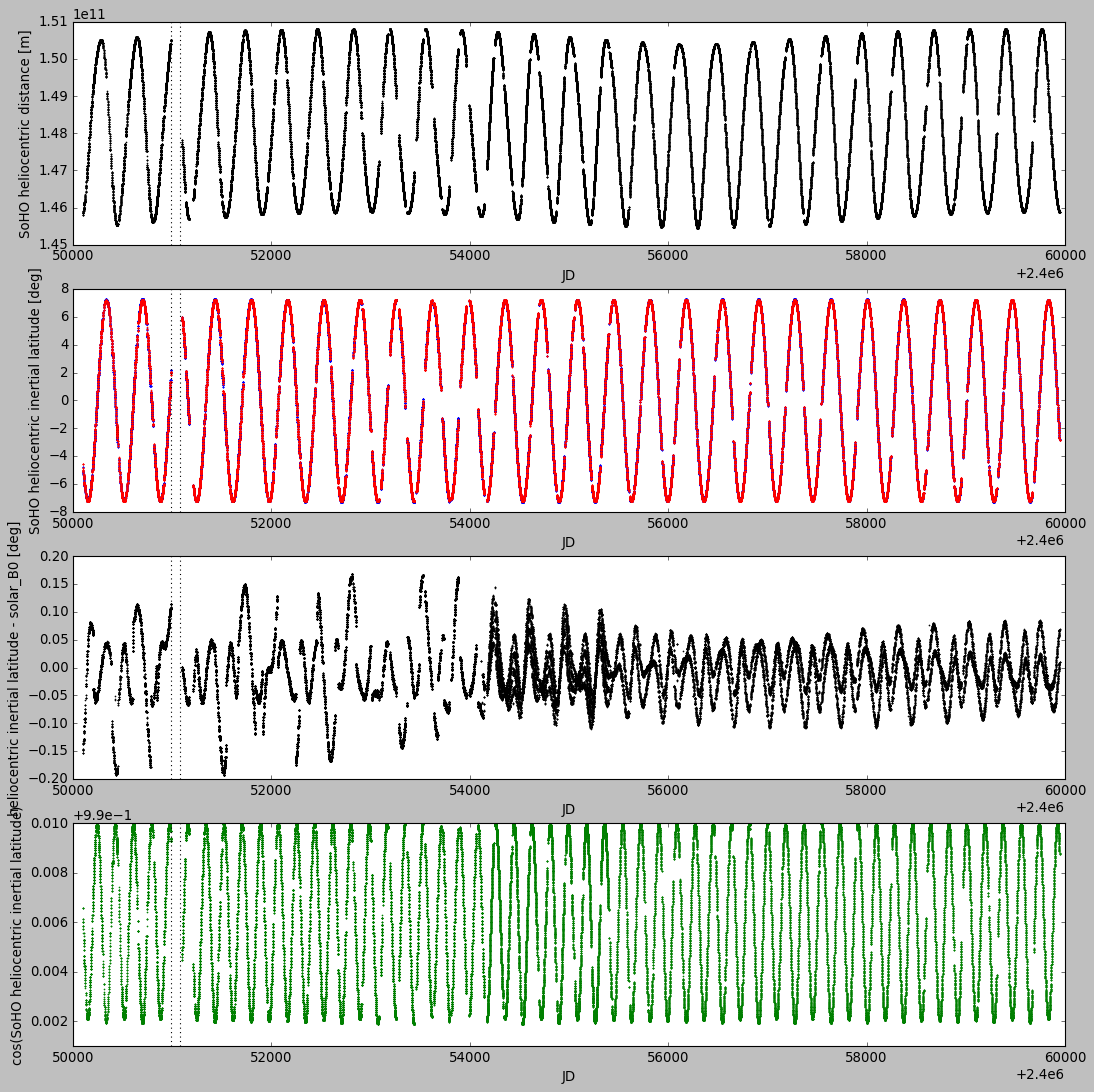

In [13]:
fig, axes = plt.subplots(4,1,figsize=(16,16))

axes[0].plot(EITmetadata['DATE-AVG'], EITmetadata['DSUN_OBS'],'k.',ls='None',ms=2)
axes[0].set_xlabel("JD")
axes[0].set_ylabel("SoHO heliocentric distance [m]")

axes[1].plot(EITmetadata['DATE-AVG'], HIcoords.lat, 'b.',ls='None',ms=2)
axes[1].set_xlabel("JD")
axes[1].set_ylabel("SoHO heliocentric inertial latitude [deg]")
#t = EITmetadata['DATE-AVG'] - EITmetadata['DATE-AVG'][0]
#axes[1].plot(EITmetadata['DATE-AVG'], 7.*np.sin((t/(51.)) + 35),color='r')

axes[1].plot(EITmetadata['DATE-AVG'], EITmetadata['SOLAR_B0'], 'r.',ls='None',ms=2)
#axes[1].set_xlabel("JD")
#axes[1].set_ylabel("SoHO tilt wrt Solar north pole [deg]")
axes[2].plot(EITmetadata['DATE-AVG'], HIcoords.lat.value - EITmetadata['SOLAR_B0'], 'k.',ls='None',ms=2)
axes[2].set_xlabel("JD")
axes[2].set_ylabel("heliocentric inertial latitude - solar_B0 [deg]")

axes[3].plot(EITmetadata['DATE-AVG'], np.cos(HIcoords.lat.to(u.rad)), 'g.',ls='None',ms=2)
axes[3].set_xlabel("JD")
axes[3].set_ylabel("cos(SoHO heliocentric inertial latitude)")


for ax in axes:
    ax.axvline(2450988,color='k',ls=":")
    ax.axvline(2451081,color='k',ls=":")

plt.show()

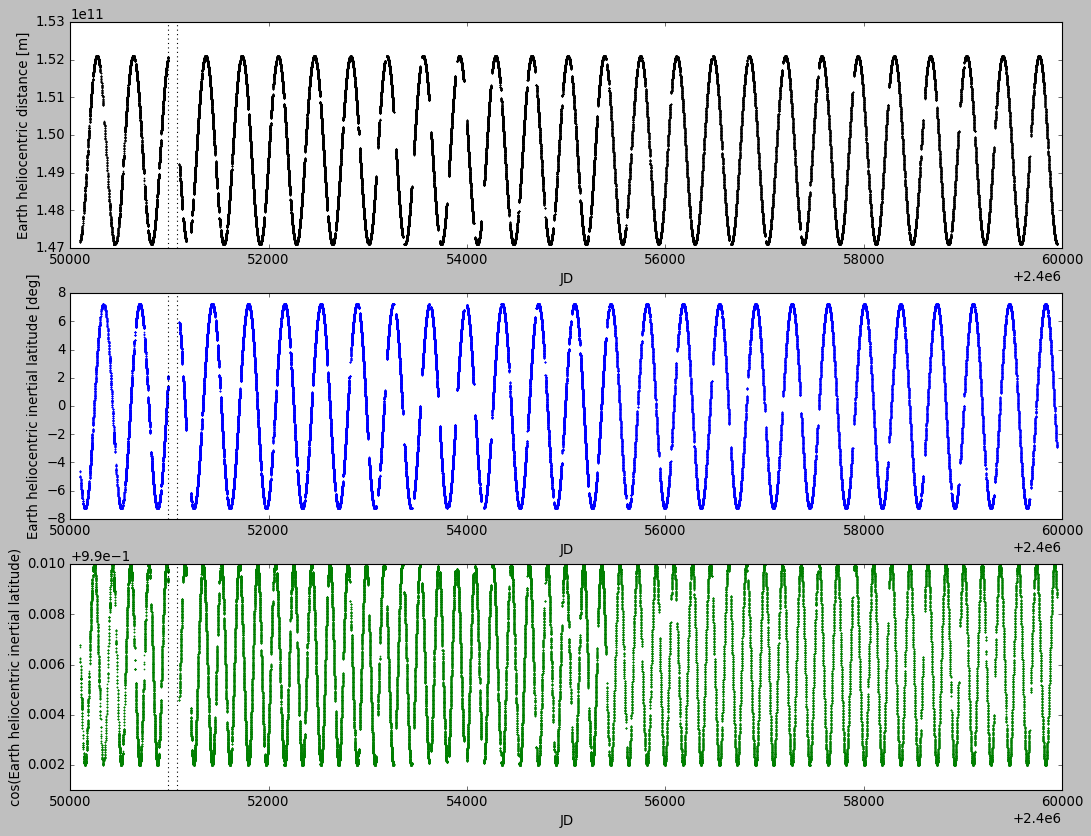

In [14]:
fig, axes = plt.subplots(3,1,figsize=(16,12))

axes[0].plot(EITmetadata['DATE-AVG'], np.sqrt(earthHAEcoords.x.to(u.m)**2 + earthHAEcoords.y.to(u.m)**2 + earthHAEcoords.z.to(u.m)**2),'k.',ls='None',ms=2)
axes[0].set_xlabel("JD")
axes[0].set_ylabel("Earth heliocentric distance [m]")

axes[1].plot(EITmetadata['DATE-AVG'], earthHIcoords.lat, 'b.',ls='None',ms=2)
axes[1].set_xlabel("JD")
axes[1].set_ylabel("Earth heliocentric inertial latitude [deg]")

axes[2].plot(EITmetadata['DATE-AVG'], np.cos(earthHIcoords.lat.to(u.rad)), 'g.',ls='None',ms=2)
axes[2].set_xlabel("JD")
axes[2].set_ylabel("cos(Earth heliocentric inertial latitude)")


for ax in axes:
    ax.axvline(2450988,color='k',ls=":")
    ax.axvline(2451081,color='k',ls=":")

plt.show()

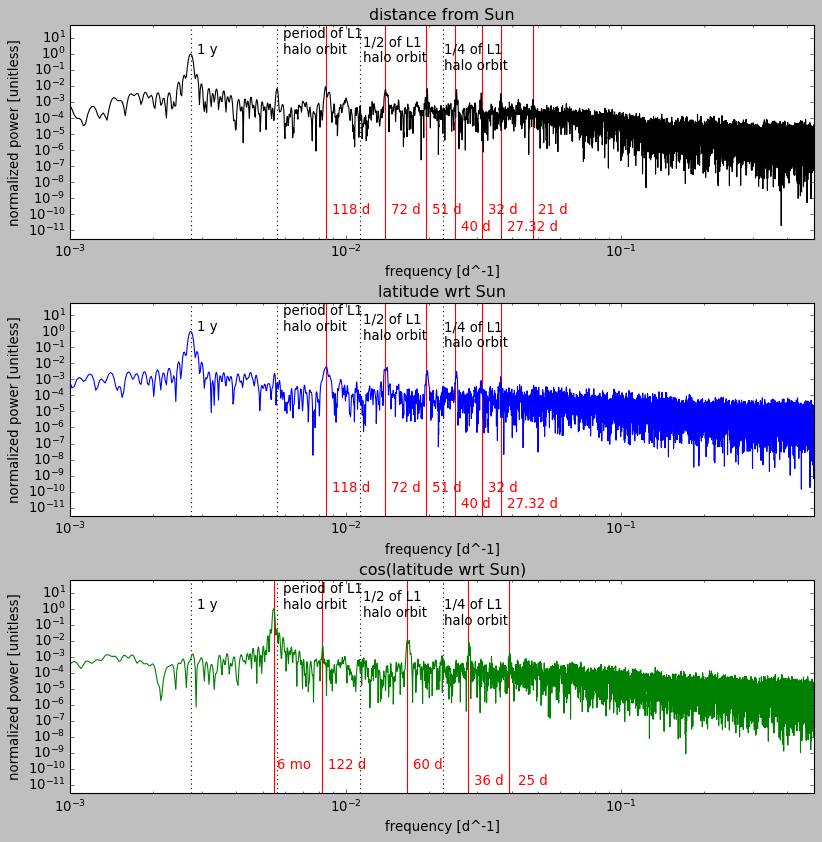

In [15]:
dFreq, dPow = LombScargle(EITmetadata['DATE-AVG'],EITmetadata['DSUN_OBS']).autopower(minimum_frequency=(1./np.ptp(EITmetadata['DATE-AVG'])), maximum_frequency=(1./2.))
lFreq, lPow = LombScargle(EITmetadata['DATE-AVG'],HIcoords.lat).autopower(minimum_frequency=(1./np.ptp(EITmetadata['DATE-AVG'])), maximum_frequency=(1./2.))
coslFreq, coslPow = LombScargle(EITmetadata['DATE-AVG'],np.cos(HIcoords.lat.to(u.rad))).autopower(minimum_frequency=(1./np.ptp(EITmetadata['DATE-AVG'])), maximum_frequency=(1./2.))

fig, axes = plt.subplots(3,1,figsize=(12,12))

axes[0].plot(dFreq,dPow,'k-',zorder=2)
axes[0].set_title("distance from Sun")
axes[1].plot(lFreq,lPow, 'b-',zorder=2)
axes[1].set_title("latitude wrt Sun")
axes[2].plot(coslFreq,coslPow, 'g-',zorder=2)
axes[2].set_title("cos(latitude wrt Sun)")

for ax in axes:
    ax.set_xlabel("frequency [d^-1]")
    ax.set_ylabel("normalized power [unitless]")
    
    #ax.axvline(1./26.24,color='k',ls=':',zorder=1)     #solar rotation
    ax.axvline(1./178., color='k',ls=':',zorder=1)     #period of L1 halo orbit, ~6 months
    ax.axvline(2./178., color='k',ls=':',zorder=1)     #1/2 period of L1 halo orbit, ~3 months
    ax.axvline(4./178., color='k',ls=':',zorder=1)     #1/4 period of L1 halo orbit, ~1.5 months
    ax.axvline(1./365.,color='k',ls=':',zorder=1)      #1 year
    #ax.axvline(3./365.25,color='r')

    #ax.text(1.05/26.24, 1.e0, 'solar'+'\n'+'rotation',fontsize=12)
    ax.text(1.05/178., 1.e0, 'period of L1'+'\n'+'halo orbit',fontsize=12)
    ax.text(1.05/365., 1.e0, '1 y',fontsize=12)
    ax.text(2.05/178., 3.e-1, '1/2 of L1'+'\n'+'halo orbit',fontsize=12,color='k')
    ax.text(4.05/178., 1.e-1, '1/4 of L1'+'\n'+'halo orbit',fontsize=12,color='k')
    #ax.text(1.05/(365*11), 1.e0, 'solar magnetic'+'\n'+'cycle',fontsize=12)
    
    ax.set_xlim(1.e-3,5.e-1)
    ax.set_ylim(3.e-12, 6.e1)
    ax.set_xscale("log")
    ax.set_yscale("log")

for ax in [axes[0]]:
    ax.axvline(1./118.,color='r',zorder=1)
    ax.axvline(1./72.,color='r',zorder=1)
    ax.axvline(1./51.,color='r',zorder=1)
    ax.axvline(1./40.,color='r',zorder=1)
    ax.axvline(1./32.,color='r',zorder=1)
    ax.axvline(1./27.32,color='r',zorder=1)
    ax.axvline(1./21,color='r',zorder=1)
        
    ax.text(1.05/118., 1.e-10, '118 d',fontsize=12,color='r')
    ax.text(1.05/72., 1.e-10, '72 d',fontsize=12,color='r')
    ax.text(1.05/51., 1.e-10, '51 d',fontsize=12,color='r')
    ax.text(1.05/40., 1.e-11, '40 d',fontsize=12,color='r')
    ax.text(1.05/32., 1.e-10, '32 d',fontsize=12,color='r')
    ax.text(1.05/27.32, 1.e-11, '27.32 d',fontsize=12,color='r')
    ax.text(1.05/21., 1.e-10, '21 d',fontsize=12,color='r')

for ax in [axes[1]]:
    ax.axvline(1./118.,color='r',zorder=1)
    ax.axvline(1./72.,color='r',zorder=1)
    ax.axvline(1./51.,color='r',zorder=1)
    ax.axvline(1./40.,color='r',zorder=1)
    ax.axvline(1./32.,color='r',zorder=1)
    ax.axvline(1./27.32,color='r',zorder=1)
    #ax.axvline(1./21,color='r',zorder=1)
        
    ax.text(1.05/118., 1.e-10, '118 d',fontsize=12,color='r')
    ax.text(1.05/72., 1.e-10, '72 d',fontsize=12,color='r')
    ax.text(1.05/51., 1.e-10, '51 d',fontsize=12,color='r')
    ax.text(1.05/40., 1.e-11, '40 d',fontsize=12,color='r')
    ax.text(1.05/32., 1.e-10, '32 d',fontsize=12,color='r')
    ax.text(1.05/27.32, 1.e-11, '27.32 d',fontsize=12,color='r')
    #ax.text(1.05/21., 1.e-10, '21 d',fontsize=12,color='r')

for ax in [axes[2]]:
    ax.axvline(2./365.25,color='r',zorder=1)
    ax.axvline(1./122.,color='r',zorder=1)
    ax.axvline(1./60.,color='r',zorder=1)
    ax.axvline(1./36.,color='r',zorder=1)
    ax.axvline(1./25.5,color='r',zorder=1)
     
    ax.text(2.05/365.25, 1.e-10, '6 mo',fontsize=12,color='r')
    ax.text(1.05/122., 1.e-10, '122 d',fontsize=12,color='r')
    ax.text(1.05/60., 1.e-10, '60 d',fontsize=12,color='r')
    ax.text(1.05/36., 1.e-11, '36 d',fontsize=12,color='r')
    ax.text(1.05/25, 1.e-11, '25 d',fontsize=12,color='r')
   
plt.subplots_adjust(hspace=0.3)
#plt.show()
plt.savefig("SOHOlocationperiodogram.pdf",bbox_inches="tight")

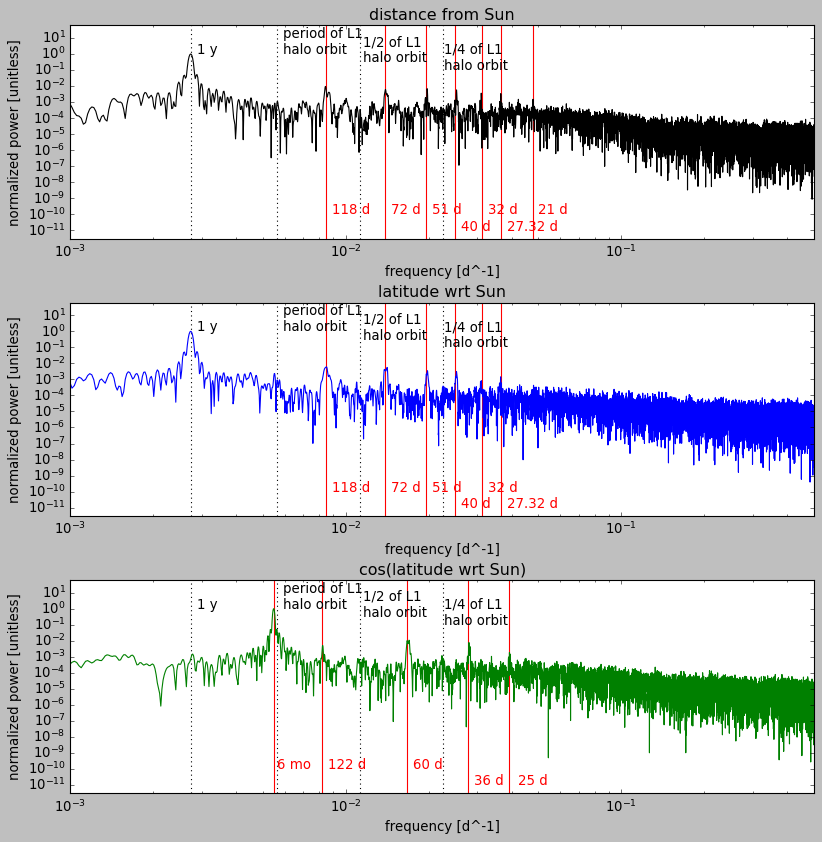

In [16]:
dFreq, dPow = LombScargle(EITmetadata['DATE-AVG'],np.sqrt(earthHAEcoords.x.to(u.m)**2 + earthHAEcoords.y.to(u.m)**2 + earthHAEcoords.z.to(u.m)**2)).autopower(minimum_frequency=(1./np.ptp(EITmetadata['DATE-AVG'])), maximum_frequency=(1./2.))
lFreq, lPow = LombScargle(EITmetadata['DATE-AVG'],earthHIcoords.lat).autopower(minimum_frequency=(1./np.ptp(EITmetadata['DATE-AVG'])), maximum_frequency=(1./2.))
coslFreq, coslPow = LombScargle(EITmetadata['DATE-AVG'],np.cos(earthHIcoords.lat.to(u.rad))).autopower(minimum_frequency=(1./np.ptp(EITmetadata['DATE-AVG'])), maximum_frequency=(1./2.))

fig, axes = plt.subplots(3,1,figsize=(12,12))

axes[0].plot(dFreq,dPow,'k-',zorder=2)
axes[0].set_title("distance from Sun")
axes[1].plot(lFreq,lPow, 'b-',zorder=2)
axes[1].set_title("latitude wrt Sun")
axes[2].plot(coslFreq,coslPow, 'g-',zorder=2)
axes[2].set_title("cos(latitude wrt Sun)")

for ax in axes:
    ax.set_xlabel("frequency [d^-1]")
    ax.set_ylabel("normalized power [unitless]")
    
    #ax.axvline(1./26.24,color='k',ls=':',zorder=1)     #solar rotation
    ax.axvline(1./178., color='k',ls=':',zorder=1)     #period of L1 halo orbit, ~6 months
    ax.axvline(2./178., color='k',ls=':',zorder=1)     #1/2 period of L1 halo orbit, ~3 months
    ax.axvline(4./178., color='k',ls=':',zorder=1)     #1/4 period of L1 halo orbit, ~1.5 months
    ax.axvline(1./365.,color='k',ls=':',zorder=1)      #1 year
    #ax.axvline(3./365.25,color='r')

    #ax.text(1.05/26.24, 1.e0, 'solar'+'\n'+'rotation',fontsize=12)
    ax.text(1.05/178., 1.e0, 'period of L1'+'\n'+'halo orbit',fontsize=12)
    ax.text(1.05/365., 1.e0, '1 y',fontsize=12)
    ax.text(2.05/178., 3.e-1, '1/2 of L1'+'\n'+'halo orbit',fontsize=12,color='k')
    ax.text(4.05/178., 1.e-1, '1/4 of L1'+'\n'+'halo orbit',fontsize=12,color='k')
    #ax.text(1.05/(365*11), 1.e0, 'solar magnetic'+'\n'+'cycle',fontsize=12)
    
    ax.set_xlim(1.e-3,5.e-1)
    ax.set_ylim(3.e-12, 6.e1)
    ax.set_xscale("log")
    ax.set_yscale("log")

for ax in [axes[0]]:
    ax.axvline(1./118.,color='r',zorder=1)
    ax.axvline(1./72.,color='r',zorder=1)
    ax.axvline(1./51.,color='r',zorder=1)
    ax.axvline(1./40.,color='r',zorder=1)
    ax.axvline(1./32.,color='r',zorder=1)
    ax.axvline(1./27.32,color='r',zorder=1)
    ax.axvline(1./21,color='r',zorder=1)
        
    ax.text(1.05/118., 1.e-10, '118 d',fontsize=12,color='r')
    ax.text(1.05/72., 1.e-10, '72 d',fontsize=12,color='r')
    ax.text(1.05/51., 1.e-10, '51 d',fontsize=12,color='r')
    ax.text(1.05/40., 1.e-11, '40 d',fontsize=12,color='r')
    ax.text(1.05/32., 1.e-10, '32 d',fontsize=12,color='r')
    ax.text(1.05/27.32, 1.e-11, '27.32 d',fontsize=12,color='r')
    ax.text(1.05/21., 1.e-10, '21 d',fontsize=12,color='r')

for ax in [axes[1]]:
    ax.axvline(1./118.,color='r',zorder=1)
    ax.axvline(1./72.,color='r',zorder=1)
    ax.axvline(1./51.,color='r',zorder=1)
    ax.axvline(1./40.,color='r',zorder=1)
    ax.axvline(1./32.,color='r',zorder=1)
    ax.axvline(1./27.32,color='r',zorder=1)
    #ax.axvline(1./21,color='r',zorder=1)
        
    ax.text(1.05/118., 1.e-10, '118 d',fontsize=12,color='r')
    ax.text(1.05/72., 1.e-10, '72 d',fontsize=12,color='r')
    ax.text(1.05/51., 1.e-10, '51 d',fontsize=12,color='r')
    ax.text(1.05/40., 1.e-11, '40 d',fontsize=12,color='r')
    ax.text(1.05/32., 1.e-10, '32 d',fontsize=12,color='r')
    ax.text(1.05/27.32, 1.e-11, '27.32 d',fontsize=12,color='r')
    #ax.text(1.05/21., 1.e-10, '21 d',fontsize=12,color='r')

for ax in [axes[2]]:
    ax.axvline(2./365.25,color='r',zorder=1)
    ax.axvline(1./122.,color='r',zorder=1)
    ax.axvline(1./60.,color='r',zorder=1)
    ax.axvline(1./36.,color='r',zorder=1)
    ax.axvline(1./25.5,color='r',zorder=1)
     
    ax.text(2.05/365.25, 1.e-10, '6 mo',fontsize=12,color='r')
    ax.text(1.05/122., 1.e-10, '122 d',fontsize=12,color='r')
    ax.text(1.05/60., 1.e-10, '60 d',fontsize=12,color='r')
    ax.text(1.05/36., 1.e-11, '36 d',fontsize=12,color='r')
    ax.text(1.05/25, 1.e-11, '25 d',fontsize=12,color='r')
   
plt.subplots_adjust(hspace=0.3)
#plt.show()
plt.savefig("Earthlocationperiodogram.pdf",bbox_inches="tight")

In [17]:
jan1_1996 = '1996-01-01T00:00:00.000Z'
jan1_1996 = astropy.time.Time(jan1_1996).jd
print(jan1_1996)

jan1_1997 = '1997-01-01T00:00:00.000Z'
jan1_1997 = astropy.time.Time(jan1_1997).jd
print(jan1_1997)


jan1_1999 = '1999-01-01T00:00:00.000Z'
jan1_1999 = astropy.time.Time(jan1_1999).jd
print(jan1_1999)

jan1_2001 = '2001-01-01T00:00:00.000Z'
jan1_2001 = astropy.time.Time(jan1_2001).jd
print(jan1_2001)

2450083.5
2450449.5
2451179.5
2451910.5


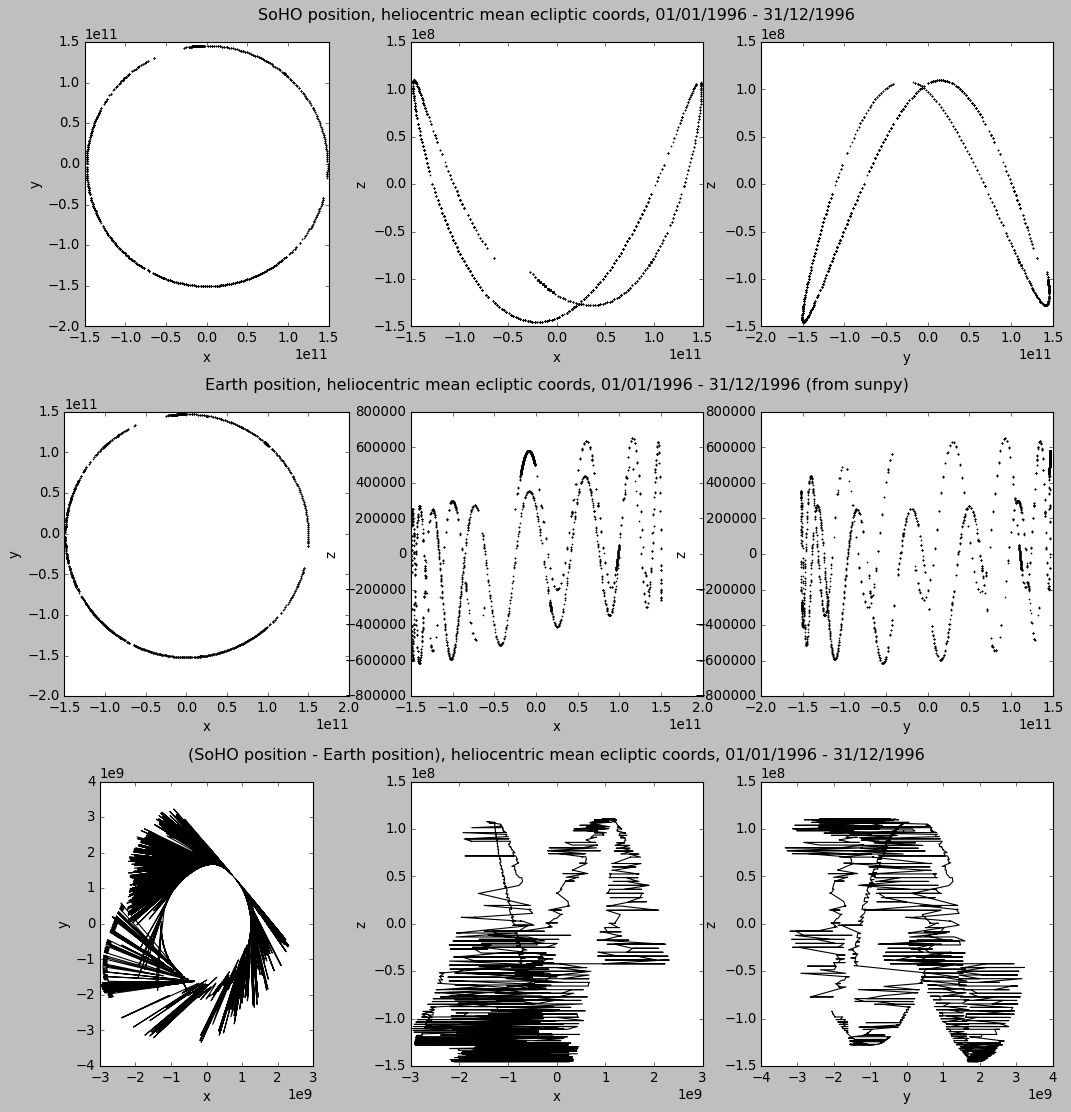

In [18]:
tmask = (EITmetadata['DATE-AVG'] >= jan1_1996) &  (EITmetadata['DATE-AVG'] < jan1_1997)

fig, axes = plt.subplots(3,3,figsize=(16,16))

axes[0,1].set_title("SoHO position, heliocentric mean ecliptic coords, 01/01/1996 - 31/12/1996",pad=20)
axes[0,0].plot(HAEcoords.x[tmask], HAEcoords.y[tmask], 'k.',ms=2,alpha=1)
axes[0,1].plot(HAEcoords.x[tmask], HAEcoords.z[tmask], 'k.',ms=2,alpha=1)
axes[0,2].plot(HAEcoords.y[tmask], HAEcoords.z[tmask], 'k.',ms=2,alpha=1)

axes[1,1].set_title("Earth position, heliocentric mean ecliptic coords, 01/01/1996 - 31/12/1996 (from sunpy)",pad=20)
axes[1,0].plot(earthHAEcoords.x.to(u.m)[tmask], earthHAEcoords.y.to(u.m)[tmask], 'k.',ms=2,alpha=1)
axes[1,1].plot(earthHAEcoords.x.to(u.m)[tmask], earthHAEcoords.z.to(u.m)[tmask], 'k.',ms=2,alpha=1)
axes[1,2].plot(earthHAEcoords.y.to(u.m)[tmask], earthHAEcoords.z.to(u.m)[tmask], 'k.',ms=2,alpha=1)
"""

axes[2,0].set_title("astropy Earth position 01/01/1996 - 31/12/1996")
axes[2,0].plot(earthAstropyHAE.x.to(u.m)[tmask], earthAstropyHAE.y.to(u.m)[tmask], 'k.',ms=2,alpha=1)
axes[2,1].plot(earthAstropyHAE.x.to(u.m)[tmask], earthAstropyHAE.z.to(u.m)[tmask], 'k.',ms=2,alpha=1)
axes[2,2].plot(earthAstropyHAE.y.to(u.m)[tmask], earthAstropyHAE.z.to(u.m)[tmask], 'k.',ms=2,alpha=1)

axes[3,0].set_title("sunpy - astropy Earth position 01/01/1996 - 31/12/1996")
axes[3,0].plot(earthHAEcoords.x.to(u.m)[tmask] - earthAstropyHAE.x.to(u.m)[tmask], earthHAEcoords.y.to(u.m)[tmask] - earthAstropyHAE.y.to(u.m)[tmask], 'k.',ms=2,alpha=1)
axes[3,1].plot(earthHAEcoords.x.to(u.m)[tmask] - earthAstropyHAE.x.to(u.m)[tmask], earthHAEcoords.z.to(u.m)[tmask] - earthAstropyHAE.z.to(u.m)[tmask], 'k.',ms=2,alpha=1)
axes[3,2].plot(earthHAEcoords.y.to(u.m)[tmask] - earthAstropyHAE.y.to(u.m)[tmask], earthHAEcoords.z.to(u.m)[tmask] - earthAstropyHAE.z.to(u.m)[tmask], 'k.',ms=2,alpha=1)
"""

axes[2,1].set_title("(SoHO position - Earth position), heliocentric mean ecliptic coords, 01/01/1996 - 31/12/1996",pad=20)
axes[2,0].plot(HAEcoords.x[tmask] - earthHAEcoords.x.to(u.m)[tmask], HAEcoords.y[tmask] - earthHAEcoords.y.to(u.m)[tmask], 'k-',ms=2,alpha=1)
axes[2,1].plot(HAEcoords.x[tmask] - earthHAEcoords.x.to(u.m)[tmask], HAEcoords.z[tmask] - earthHAEcoords.z.to(u.m)[tmask], 'k-',ms=2,alpha=1)
axes[2,2].plot(HAEcoords.y[tmask] - earthHAEcoords.y.to(u.m)[tmask], HAEcoords.z[tmask] - earthHAEcoords.z.to(u.m)[tmask], 'k-',ms=2,alpha=1)

for ax in axes[:,0]:
    ax.set_xlabel("x")
    ax.set_ylabel("y")

for ax in axes[:,1]:
    ax.set_xlabel("x")
    ax.set_ylabel("z")

for ax in axes[:,2]:
    ax.set_xlabel("y")
    ax.set_ylabel("z")

axes[0,0].set_aspect("equal")
axes[1,0].set_aspect("equal")
axes[2,0].set_aspect("equal")

plt.subplots_adjust(hspace=0.3)
plt.show()
#plt.savefig("./SoHOposition.pdf",bbox_inches="tight")

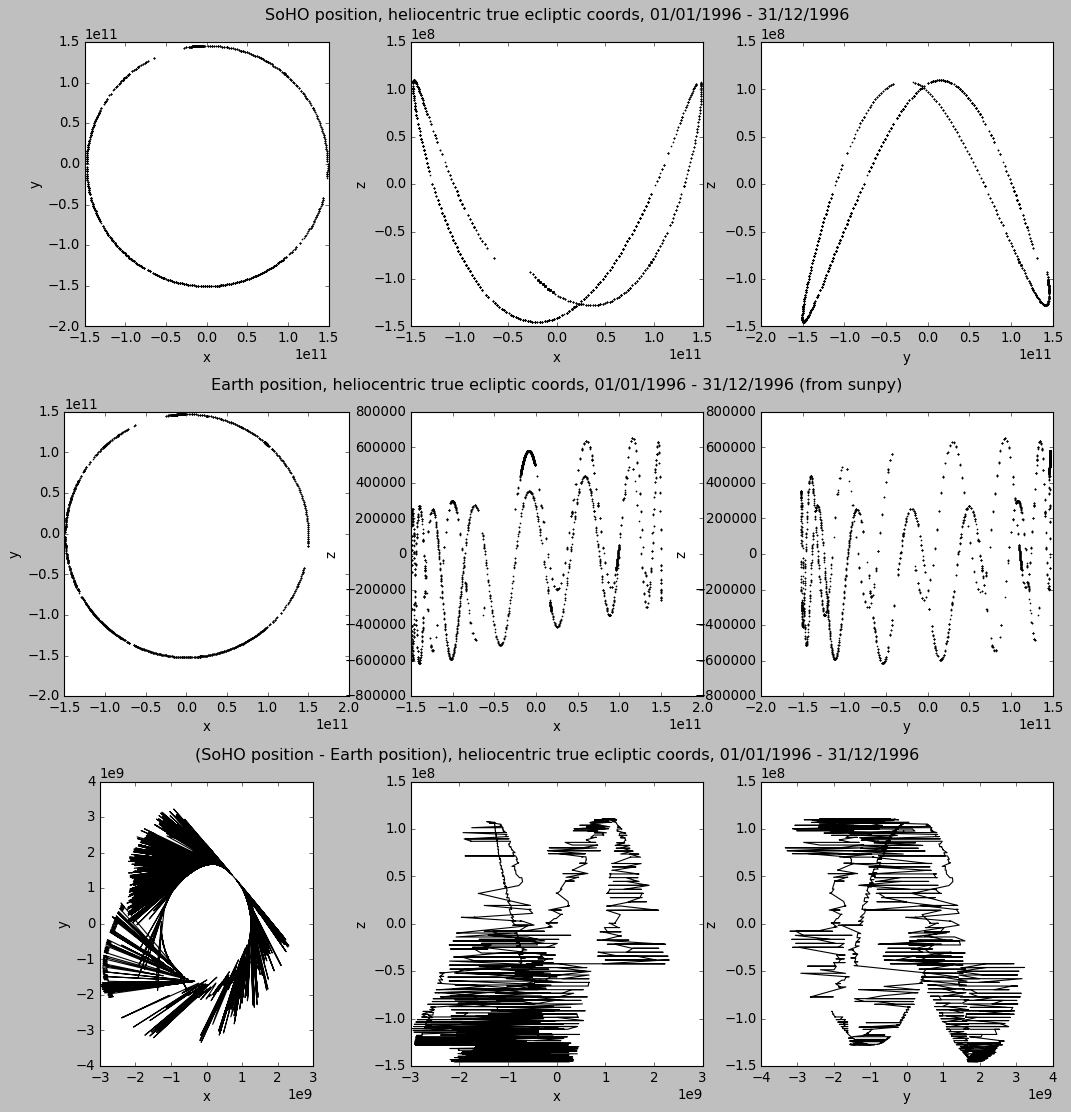

In [19]:
tmask = (EITmetadata['DATE-AVG'] >= jan1_1996) &  (EITmetadata['DATE-AVG'] < jan1_1997)

fig, axes = plt.subplots(3,3,figsize=(16,16))

axes[0,1].set_title("SoHO position, heliocentric true ecliptic coords, 01/01/1996 - 31/12/1996",pad=20)
axes[0,0].plot(HTEcoords.x[tmask], HTEcoords.y[tmask], 'k.',ms=2,alpha=1)
axes[0,1].plot(HTEcoords.x[tmask], HTEcoords.z[tmask], 'k.',ms=2,alpha=1)
axes[0,2].plot(HTEcoords.y[tmask], HTEcoords.z[tmask], 'k.',ms=2,alpha=1)

axes[1,1].set_title("Earth position, heliocentric true ecliptic coords, 01/01/1996 - 31/12/1996 (from sunpy)",pad=20)
axes[1,0].plot(earthHTEcoords.x.to(u.m)[tmask], earthHTEcoords.y.to(u.m)[tmask], 'k.',ms=2,alpha=1)
axes[1,1].plot(earthHTEcoords.x.to(u.m)[tmask], earthHTEcoords.z.to(u.m)[tmask], 'k.',ms=2,alpha=1)
axes[1,2].plot(earthHTEcoords.y.to(u.m)[tmask], earthHTEcoords.z.to(u.m)[tmask], 'k.',ms=2,alpha=1)

axes[2,1].set_title("(SoHO position - Earth position), heliocentric true ecliptic coords, 01/01/1996 - 31/12/1996",pad=20)
axes[2,0].plot(HTEcoords.x[tmask] - earthHTEcoords.x.to(u.m)[tmask], HTEcoords.y[tmask] - earthHTEcoords.y.to(u.m)[tmask], 'k-',ms=2,alpha=1)
axes[2,1].plot(HTEcoords.x[tmask] - earthHTEcoords.x.to(u.m)[tmask], HTEcoords.z[tmask] - earthHTEcoords.z.to(u.m)[tmask], 'k-',ms=2,alpha=1)
axes[2,2].plot(HTEcoords.y[tmask] - earthHTEcoords.y.to(u.m)[tmask], HTEcoords.z[tmask] - earthHTEcoords.z.to(u.m)[tmask], 'k-',ms=2,alpha=1)

for ax in axes[:,0]:
    ax.set_xlabel("x")
    ax.set_ylabel("y")

for ax in axes[:,1]:
    ax.set_xlabel("x")
    ax.set_ylabel("z")

for ax in axes[:,2]:
    ax.set_xlabel("y")
    ax.set_ylabel("z")

axes[0,0].set_aspect("equal")
axes[1,0].set_aspect("equal")
axes[2,0].set_aspect("equal")

plt.subplots_adjust(hspace=0.3)
plt.show()
#plt.savefig("./SoHOposition.pdf",bbox_inches="tight")

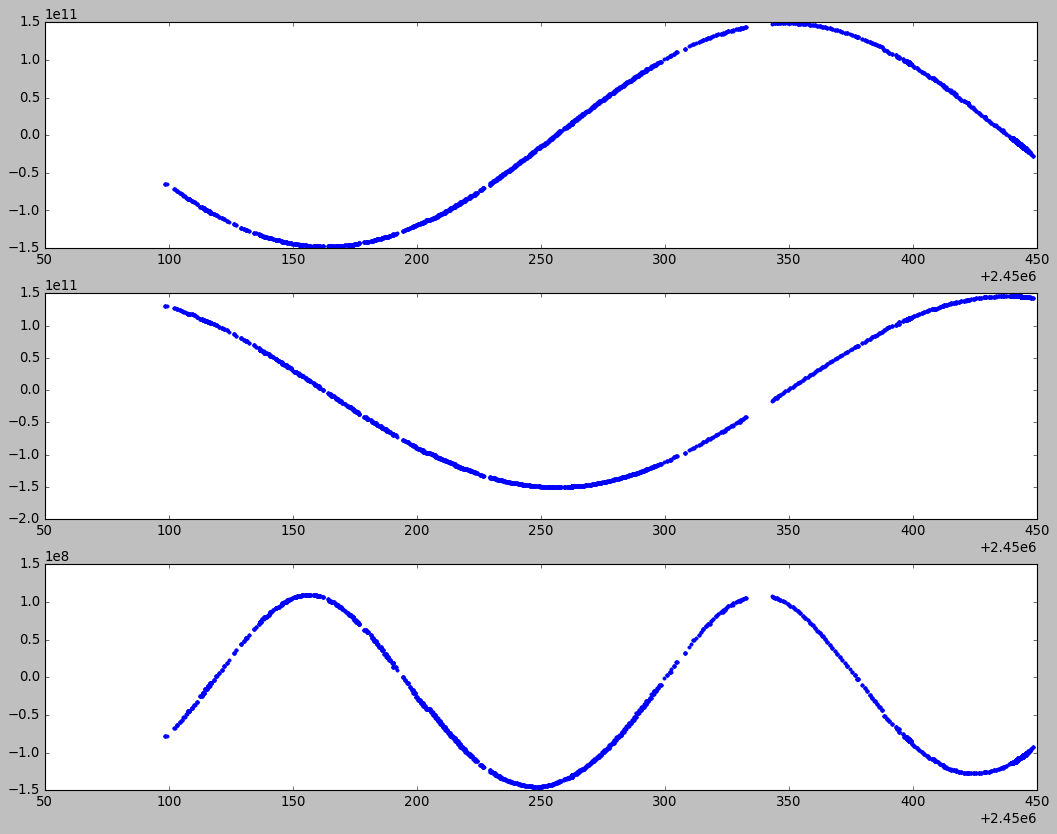

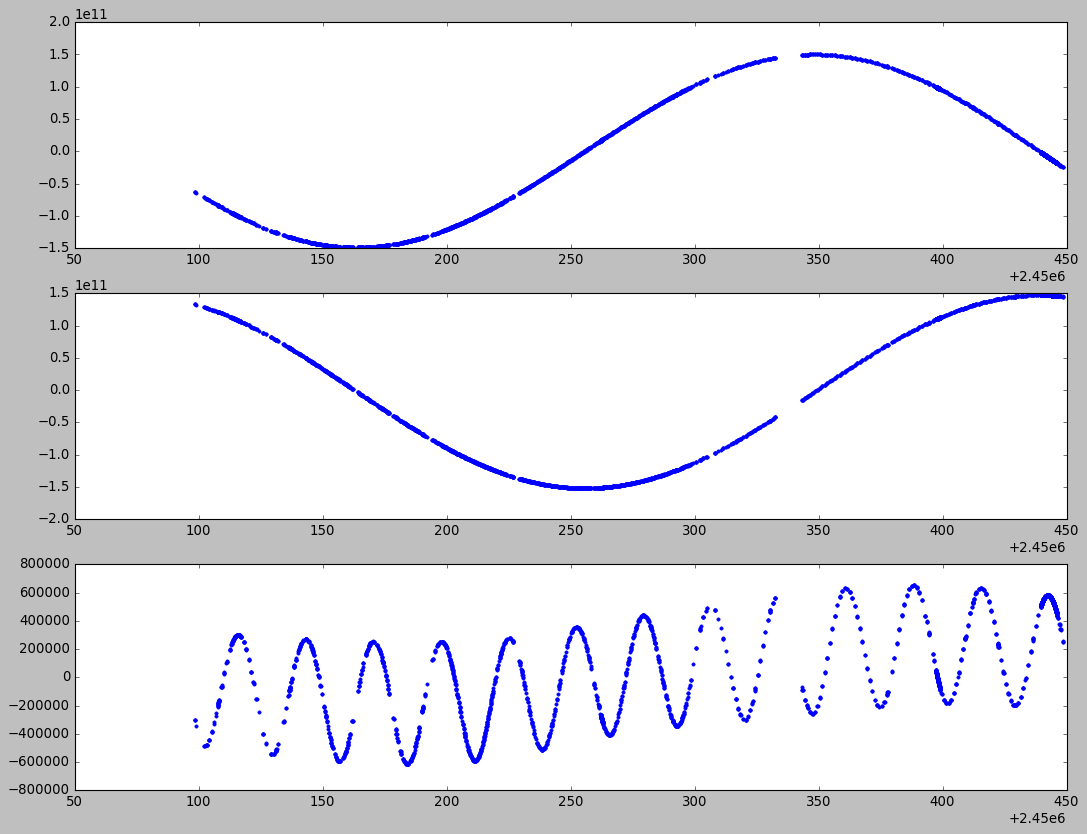

In [20]:
fig, axes = plt.subplots(3,1,figsize=(16,12))
axes[0].plot(EITmetadata['DATE-AVG'][tmask],HAEcoords.x[tmask],'b.')
axes[1].plot(EITmetadata['DATE-AVG'][tmask],HAEcoords.y[tmask],'b.')
axes[2].plot(EITmetadata['DATE-AVG'][tmask],HAEcoords.z[tmask],'b.')
plt.show()

fig, axes = plt.subplots(3,1,figsize=(16,12))
axes[0].plot(EITmetadata['DATE-AVG'][tmask],earthHAEcoords.x.to(u.m)[tmask],'b.')
axes[1].plot(EITmetadata['DATE-AVG'][tmask],earthHAEcoords.y.to(u.m)[tmask],'b.')
axes[2].plot(EITmetadata['DATE-AVG'][tmask],earthHAEcoords.z.to(u.m)[tmask],'b.')
plt.show()

In [21]:
print(EITmetadata.colnames)

['DATE-BEG', 'DATE-AVG', 'XPOSURE', 'CMDXPOS', 'SHUTCLS', 'FILTER', 'WAVELNTH', 'OBJECT', 'SCI_OBJ', 'OBS_PROG', 'CMP_NO', 'UCD', 'EXPMODE', 'LYNESYNC', 'ROUTPORT', 'NLEBPROC', 'LEBPROC1', 'LEBPROC2', 'LEBPROC3', 'WCSNAME', 'CTYPE1', 'CTYPE2', 'CUNIT1', 'CUNIT2', 'PC1_1', 'PC1_2', 'PC2_1', 'PC2_2', 'CDELT1', 'CDELT2', 'CRVAL1', 'CRVAL2', 'CRPIX1', 'CRPIX2', 'CROTA', 'CFTEMP', 'CCDTEMP', 'SOLAR_B0', 'RSUN_ARC', 'RSUN_OBS', 'RSUN_REF', 'CAR_ROT', 'DSUN_OBS', 'SC_X0', 'SC_Y0', 'SC_ROLL', 'HAEX_OBS', 'HAEY_OBS', 'HAEZ_OBS', 'HI-LAT-DEG', 'HI-LON-DEG']


# Plot light curve value against HI latitude

(22134, 5)
(22134,)
(20724, 5)
(20724,)


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(22861, 5)
(22861,)
(22070, 5)
(22070,)


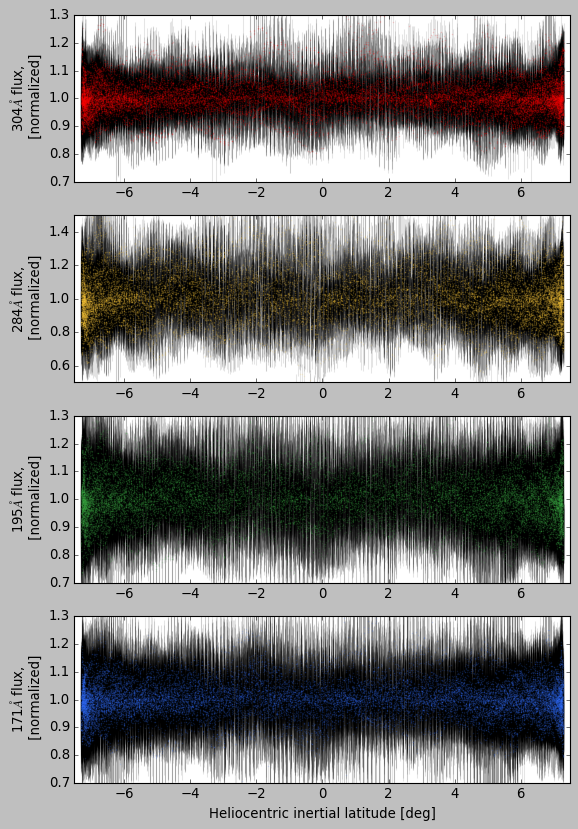

In [10]:
filters = [304, 284, 195, 171]
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
fig, axes = plt.subplots(4,1,figsize=(8,12))


for i, f in enumerate(filters):
    LC = np.genfromtxt("./EIT/EIT{0}_LC_corrected_2008onwards.txt".format(f))
    #LC = np.genfromtxt("./EIT/EIT{0}_LC_corrected_all.txt".format(f))
    metadata = Table.read("./EIT/EIT{0}_metadata.txt".format(f),format='ascii')
    print(np.shape(LC))
    print(np.shape(metadata))

    ts = LC[:,0]
    fs = LC[:,1]
    us = LC[:,2]
    
    cosLat = np.cos(metadata['HI-LAT-DEG']*(np.pi/180.))
    
    firstMin = np.argmin(cosLat[0:1000])
    firstMax = np.argmax(cosLat[0:1500])

    lastMin = np.argmin(cosLat[-1000:]) + len(metadata) - 1000
    lastMax = np.argmax(cosLat[-1000:]) + len(metadata) - 1000
    
    timeIntervalIdx = firstMax - firstMin
    timeInterval = metadata['DATE-AVG'][firstMax] - metadata['DATE-AVG'][firstMin]
    timeIntervalEnd = metadata['DATE-AVG'][lastMax] - metadata['DATE-AVG'][lastMin]
    
    optimaTimes = np.arange(metadata['DATE-AVG'][firstMin], metadata['DATE-AVG'][lastMax], timeIntervalEnd)
    
    minTimes = []
    maxTimes = []
    
    tTest = metadata['DATE-AVG'][0]
    
    while tTest < metadata['DATE-AVG'][-1]: 
        tMask = (np.abs(metadata['DATE-AVG'] - tTest) < 100.)

        try:
            minIdx = np.argmin(cosLat[tMask])
            maxIdx = np.argmax(cosLat[tMask])
        
            tMin = metadata['DATE-AVG'][tMask][minIdx]
            tMax = metadata['DATE-AVG'][tMask][maxIdx]
            if cosLat[tMask][minIdx] < np.cos((7.1*(np.pi/180.))):
                minTimes.append(tMin)
            if cosLat[tMask][maxIdx] > np.cos((0.1*(np.pi/180.))):
                maxTimes.append(tMax)
            
            tTest = tTest + 150.
        except ValueError:
            tTest = tTest + 150.
    
    optTimes = minTimes + maxTimes
    optTimes = np.array(optTimes)
    optTimes = np.unique(optTimes)
    
    minTimes = np.array(minTimes)
    maxTimes = np.array(maxTimes)
    
    minTimes = np.unique(minTimes)
    maxTimes = np.unique(maxTimes)
    optTimes_infill = []

    for j in range(len(optTimes)-1):
        optTimes_infill.append(optTimes[j])
        if optTimes[j+1] - optTimes[j] > 100.:
            optTimes_infill.append(optTimes[j] + ((optTimes[j+1] - optTimes[j])/2.))
    
    optTimes_infill.append(metadata['DATE-AVG'][lastMax])
    optTimes_infill = np.array(optTimes_infill)
    '''
    #fig2, ax2 = plt.subplots(1,1,figsize=(20,6))
    #ax2.plot(metadata['DATE-AVG'], cosLat, 'k.',ms=2)
    #ax2.plot(metadata['DATE-AVG'], fs/np.median(fs[~np.isnan(fs)]), 'r.')
    fig2, ax2 = plt.subplots(1,1,figsize=(8,8))
    ax2.scatter(HIcoords.lat.value, fs/np.median(fs[~np.isnan(fs)]), c=ts, cmap='magma', edgecolor='None', alpha=0.5)
    ax2.set_ylim(0.5,3.5)
    #for t in optTimes_infill:
    #    ax2.axvline(t, color='g',lw=3)
    
    #ax2.set_ylim(np.cos((7.35*np.pi/180.)),1.0001)
    plt.show()
    '''

    plotcolor = cs[i]

    latList = []
    tList = []
    fluxnormList = []
    unormList = []

    for j in range(len(optTimes_infill) - 1):
        tMask = (ts > optTimes_infill[j]) & (ts <= optTimes_infill[j+1])

        fluxnorm = np.median(fs[tMask][~np.isnan(fs[tMask])])

        axes[i].errorbar(metadata['HI-LAT-DEG'][tMask], fs[tMask]/fluxnorm, yerr=us[tMask]/fluxnorm, ls='None', elinewidth=1, capsize=0, marker='.',ms=2,c=plotcolor,ecolor='k',alpha=0.1)

        t_ = ts[tMask]
        lat_ = metadata['HI-LAT-DEG'][tMask]
        fluxnorm_ = fs[tMask]/fluxnorm
        unorm_ = us[tMask]/fluxnorm

        latList.extend(lat_)
        tList.extend(t_)
        fluxnormList.extend(fluxnorm_)
        unormList.extend(unorm_)
        
    axes[i].set_ylabel(r"{0}$\AA$ flux,""\n"" [normalized]".format(f))
    axes[i].set_xlim(-7.5,7.5)

    latList = np.array((latList))
    tList = np.array((tList))
    unormList = np.array((unormList))
    fluxnormList = np.array((fluxnormList))

    fluxnormList = fluxnormList[np.argsort(latList)]
    tList = tList[np.argsort(latList)]
    unormList = unormList[np.argsort(latList)]
    latList = latList[np.argsort(latList)]

    tList = tList[~np.isnan(fluxnormList)]
    latList = latList[~np.isnan(fluxnormList)]
    unormList = unormList[~np.isnan(fluxnormList)]
    fluxnormList = fluxnormList[~np.isnan(fluxnormList)]
    
    # note that flux in these arrays is normalized over each "sweep" of a solar hemisphere, i.e. scan from pole to equator or vice versa
    toSave = np.vstack((latList.T, fluxnormList.T, unormList.T, tList.T)).T
    np.savetxt("./heliocentricLat_{0}_corrected_2008onwards.txt".format(f),toSave,header='heliocentricLat[deg] normalizedFlux[unitless] normalizedFluxUnc[unitless] avgTimeOfObservation[JD]')
    #np.savetxt("./heliocentricLat_{0}_corrected_all.txt".format(f),toSave,header='heliocentricLat[deg] normalizedFlux[unitless] normalizedFluxUnc[unitless] avgTimeOfObservation[JD]')


axes[0].set_ylim(0.7,1.3)
axes[1].set_ylim(0.5,1.5)
axes[2].set_ylim(0.7,1.3)
axes[3].set_ylim(0.7,1.3)

axes[3].set_xlabel("Heliocentric inertial latitude [deg]")
#plt.show()
plt.savefig("./SOHO_flux_vs_heliocentricLat_halfNorm_corrected_2008onwards.pdf")
#plt.savefig("./SOHO_flux_vs_heliocentricLat_halfNorm_corrected_all.pdf")

In [11]:
betweenOptima = (optTimes_infill[1:] - optTimes_infill[:-1])
meanBetweenOptima = (np.mean(betweenOptima))

print(meanBetweenOptima/(365.25*11))

0.02251628416533097


## Bin the above data and plot again 

In [12]:
def percentile16(x):
    return np.percentile(x,q=16)
def percentile84(x):
    return np.percentile(x,q=84)

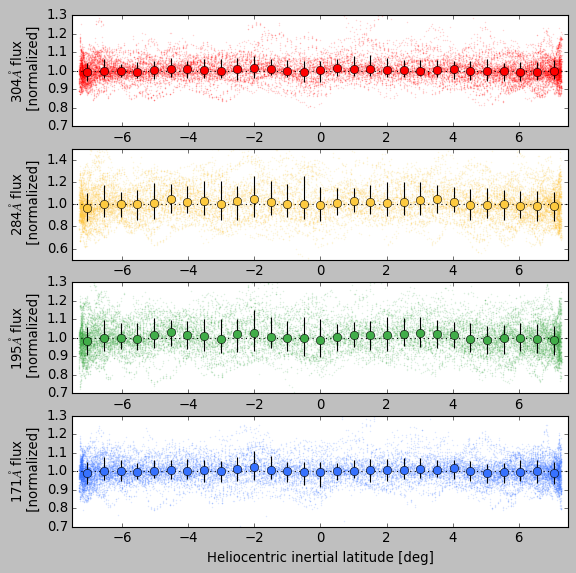

In [13]:
fig, axes = plt.subplots(4,1,figsize=(8,8))

for i, f in enumerate(filters):
    latArr = np.genfromtxt("./heliocentricLat_{0}_corrected_2008onwards.txt".format(f))
    #latArr = np.genfromtxt("./heliocentricLat_{0}_corrected_all.txt".format(f))
    
    plotcolor = cs[i]
    axes[i].plot(latArr[:,0], latArr[:,1], ls='None', marker='.',ms=2,c=plotcolor,alpha=0.1,zorder=1)
    
    binEdges = np.linspace(-7.3, 7.3,30)

    fluxnorm_50 = binned_statistic(latArr[:,0], latArr[:,1], statistic='median',bins = binEdges)[0]
    fluxnorm_16 = binned_statistic(latArr[:,0], latArr[:,1], statistic=percentile16,bins = binEdges)[0]
    fluxnorm_84 = binned_statistic(latArr[:,0], latArr[:,1], statistic=percentile84,bins = binEdges)[0]

    le = fluxnorm_50 - fluxnorm_16
    ue = fluxnorm_84 - fluxnorm_50
    err2d  = np.vstack((le,ue))

    binCenters = (binEdges[0:-1] + binEdges[1:])/2.
    axes[i].errorbar(binCenters, fluxnorm_50, yerr=err2d, ls='None', elinewidth=1, capsize=0, marker='.',ms=15,markeredgecolor='k',c=plotcolor,ecolor='k',alpha=1,zorder=3) 
        
    axes[i].set_ylabel(r"{0}$\AA$ flux""\n"" [normalized]".format(f))
    axes[i].set_xlim(-7.5,7.5)
    axes[i].axhline(1.0,color='k',ls=':',zorder=2)
    
axes[0].set_ylim(0.7,1.3)
axes[1].set_ylim(0.5,1.5)
axes[2].set_ylim(0.7,1.3)
axes[3].set_ylim(0.7,1.3)

axes[3].set_xlabel("Heliocentric inertial latitude [deg]")
#plt.show()
plt.savefig("./SOHO_flux_vs_heliocentricLat_binned_halfNorm_corrected_2008onwards.pdf")
#plt.savefig("./SOHO_flux_vs_heliocentricLat_binned_halfNorm_corrected_all.pdf")

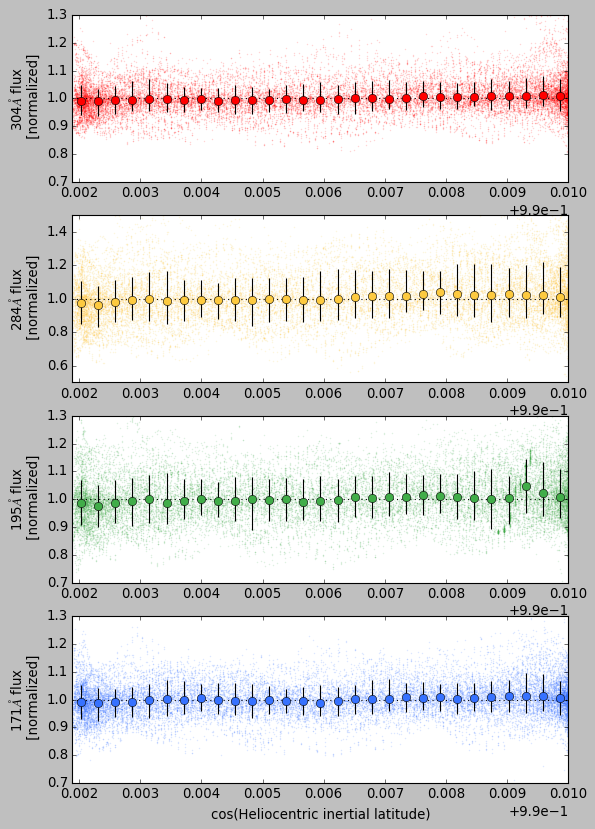

In [15]:
fig, axes = plt.subplots(4,1,figsize=(8,12))

for i, f in enumerate(filters):
    latArr = np.genfromtxt("./heliocentricLat_{0}_corrected_2008onwards.txt".format(f))
    #latArr = np.genfromtxt("./heliocentricLat_{0}_corrected_all.txt".format(f))
    
    plotcolor = cs[i]
    axes[i].plot(np.cos(latArr[:,0]*(np.pi/180.)), latArr[:,1], ls='None', marker='.',ms=2,c=plotcolor,alpha=0.1,zorder=1)
    
    binEdges = np.linspace(np.min(np.cos(latArr[:,0]*(np.pi/180.))), 1.,30)

    fluxnorm_50 = binned_statistic(np.cos(latArr[:,0]*(np.pi/180.)), latArr[:,1], statistic='median',bins = binEdges)[0]
    fluxnorm_16 = binned_statistic(np.cos(latArr[:,0]*(np.pi/180.)), latArr[:,1], statistic=percentile16,bins = binEdges)[0]
    fluxnorm_84 = binned_statistic(np.cos(latArr[:,0]*(np.pi/180.)), latArr[:,1], statistic=percentile84,bins = binEdges)[0]

    le = fluxnorm_50 - fluxnorm_16
    ue = fluxnorm_84 - fluxnorm_50
    err2d  = np.vstack((le,ue))

    binCenters = (binEdges[0:-1] + binEdges[1:])/2.
    axes[i].errorbar(binCenters, fluxnorm_50, yerr=err2d, ls='None', elinewidth=1, capsize=0, marker='.',ms=15,markeredgecolor='k',c=plotcolor,ecolor='k',alpha=1,zorder=3) 
        
    axes[i].set_ylabel(r"{0}$\AA$ flux""\n"" [normalized]".format(f))
    axes[i].set_xlim(np.min(np.cos(latArr[:,0]*(np.pi/180.))), 1.)
    axes[i].axhline(1.0,color='k',ls=':',zorder=2)
    
axes[0].set_ylim(0.7,1.3)
axes[1].set_ylim(0.5,1.5)
axes[2].set_ylim(0.7,1.3)
axes[3].set_ylim(0.7,1.3)

#axes[3].set_xlabel("cos(Heliocentric inertial latitude)")
axes[3].set_xlabel("cos(Heliocentric inertial latitude)")
#plt.show()
plt.savefig("./SOHO_flux_vs_cosheliocentricLat_binned_halfNorm_corrected_2008onwards.pdf")
#plt.savefig("./SOHO_flux_vs_cosheliocentricLat_binned_halfNorm_corrected_all.pdf")

# Filter keyword

In [13]:
print(set(EITmetadata['FILTER']))

EITmetadata['FILTERFLAG'] = 0

for i in range(len(EITmetadata)):
    if EITmetadata['FILTER'][i] == 'Clear':
        EITmetadata['FILTERFLAG'][i] = 0
    elif EITmetadata['FILTER'][i] == 'Al_sup':
        EITmetadata['FILTERFLAG'][i] = 1
    elif EITmetadata['FILTER'][i] == 'Al_+1':
        EITmetadata['FILTERFLAG'][i] = 2

{'Al_+1', 'Al_sup', 'Clear'}


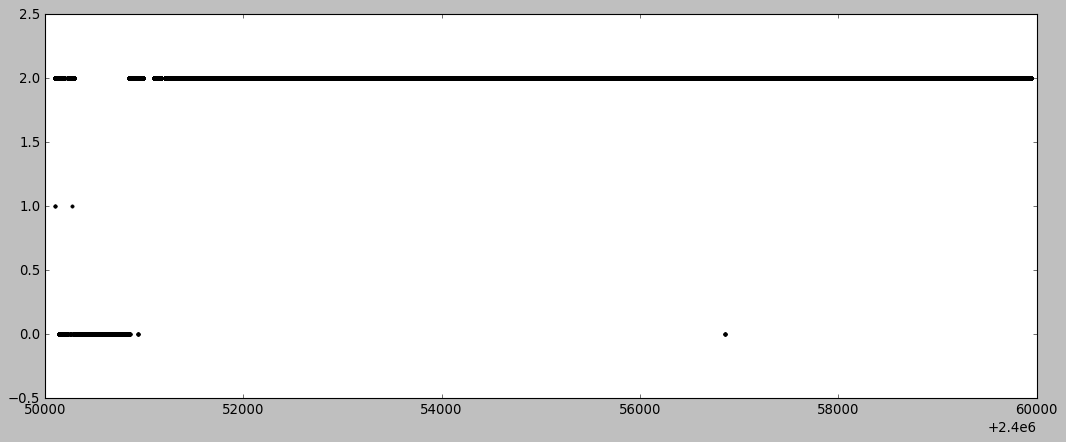

In [14]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot(EITmetadata['DATE-AVG'],EITmetadata['FILTERFLAG'],'k.')
ax.set_ylim(-0.5,2.5)
plt.show()

In [15]:
print(EITmetadata.colnames)

['DATE-BEG', 'DATE-AVG', 'XPOSURE', 'CMDXPOS', 'SHUTCLS', 'FILTER', 'WAVELNTH', 'OBJECT', 'SCI_OBJ', 'OBS_PROG', 'CMP_NO', 'UCD', 'EXPMODE', 'LYNESYNC', 'ROUTPORT', 'NLEBPROC', 'LEBPROC1', 'LEBPROC2', 'LEBPROC3', 'WCSNAME', 'CTYPE1', 'CTYPE2', 'CUNIT1', 'CUNIT2', 'PC1_1', 'PC1_2', 'PC2_1', 'PC2_2', 'CDELT1', 'CDELT2', 'CRVAL1', 'CRVAL2', 'CRPIX1', 'CRPIX2', 'CROTA', 'CFTEMP', 'CCDTEMP', 'SOLAR_B0', 'RSUN_ARC', 'RSUN_OBS', 'RSUN_REF', 'CAR_ROT', 'DSUN_OBS', 'SC_X0', 'SC_Y0', 'SC_ROLL', 'HAEX_OBS', 'HAEY_OBS', 'HAEZ_OBS', 'HI-LAT-DEG', 'HI-LON-DEG', 'FILTERFLAG']


In [18]:
print(EITmetadata['DATE-AVG'])
print(EITmetadata['DATE-AVG'][EITmetadata['FILTERFLAG']==0])

     DATE-AVG     
------------------
 2450098.536677118
2450098.5129467477
 2450099.079920463
 2450098.520678391
2450102.4025296876
2450102.2427430553
 2450102.278574815
 2450103.187562593
 2450103.240741505
2450103.2612181483
               ...
 2459944.040644259
2459944.0541246296
2459943.5500205555
 2459945.051416204
2459945.0556337037
2459944.5416762154
 2459945.041931343
2459945.0467044096
2459944.5511724884
 2459944.555384051
Length = 91883 rows
     DATE-AVG     
------------------
2450139.4015574073
2450140.3929508333
 2450140.353871308
2450140.1400064006
 2450140.358834259
2450140.3987024073
2450139.8933943054
2450140.6985606714
2450141.2688574535
2450140.7626063656
               ...
2450857.3012251854
2450857.3054996296
2450939.3113867594
2450939.3197868518
 2450939.293630185
 2450939.301777037
2456859.5497376854
 2456859.545824074
2456859.5420090393
2456859.5536735766
Length = 6083 rows


# Parker Solar Probe position

In [28]:
psp_data = Table.read("./parkerSolarProbeLocation.txt",format="ascii.basic")

psp_data['jd'] = 0.

for i in range(len(psp_data)):
    y = psp_data['YEAR'][i]
    if y % 4==0:
        dec_y = psp_data['YEAR'][i] + psp_data['DAY'][i]/366.
    else:
        dec_y = psp_data['YEAR'][i] + psp_data['DAY'][i]/366.

    psp_data[i]['jd'] = astropy.time.Time(dec_y,format="decimalyear",scale='utc').jd

print(psp_data)

YEAR DAY RAD_AU SE_LAT SE_LON         jd        
---- --- ------ ------ ------ ------------------
2018 250   0.94   -1.5  334.7  2458368.816939891
2018 251   0.94   -1.5  335.3 2458369.8142076503
2018 252   0.93   -1.6  336.0 2458370.8114754097
2018 253   0.93   -1.7  336.7 2458371.8087431695
2018 254   0.92   -1.7  337.3  2458372.806010929
2018 255   0.92   -1.8  338.0 2458373.8032786883
2018 256   0.91   -1.8  338.7  2458374.800546448
2018 257    0.9   -1.9  339.4 2458375.7978142076
2018 258    0.9   -2.0  340.1  2458376.795081967
2018 259   0.89   -2.0  340.8  2458377.792349727
2018 260   0.88   -2.1  341.6 2458378.7896174863
2018 261   0.87   -2.2  342.3 2458379.7868852457
 ... ...    ...    ...    ...                ...
2024 354   0.27   -3.2    5.0          2460664.5
2024 355   0.24   -3.1    9.5          2460665.5
2024 356    0.2   -3.0   15.7          2460666.5
2024 357   0.16   -2.7   25.1          2460667.5
2024 358   0.11   -2.0   42.0          2460668.5
2024 359   0.06    0

In [33]:
HIcoords = SkyCoord(frame='heliocentricinertial',lon=psp_data['SE_LON']*u.deg,lat=psp_data['SE_LAT']*u.deg, distance=psp_data['RAD_AU']*u.AU, obstime=astropy.time.Time(psp_data['jd'],format='jd'))
print(HIcoords)

HAEcoords = HIcoords.transform_to(astropy.coordinates.HeliocentricMeanEcliptic())
print(HAEcoords)

<SkyCoord (HeliocentricInertial: obstime=[2458368.81693989 2458369.81420765 2458370.81147541 ... 2460673.5
 2460674.5        2460675.5       ]): (lon, lat, distance) in (deg, deg, AU)
    [(-25.3, -1.5, 0.94), (-24.7, -1.5, 0.94), (-24. , -1.6, 0.93), ...,
     (-84.7, -1.1, 0.2 ), (-78.6, -1.4, 0.24), (-74.1, -1.6, 0.27)]>
<SkyCoord (HeliocentricMeanEcliptic: equinox=J2000.000, obstime=[2458368.81693989 2458369.81420765 2458370.81147541 ... 2460673.5
 2460674.5        2460675.5       ]): (lon, lat, distance) in (deg, deg, AU)
    [( 50.81503458, -4.58247683, 0.94), ( 51.41274821, -4.51364253, 0.94),
     ( 52.1215637 , -4.5322534 , 0.93), ...,
     (351.12129792, -8.32048999, 0.2 ), (357.29081928, -8.50747695, 0.24),
     (  1.84376072, -8.57191285, 0.27)]>


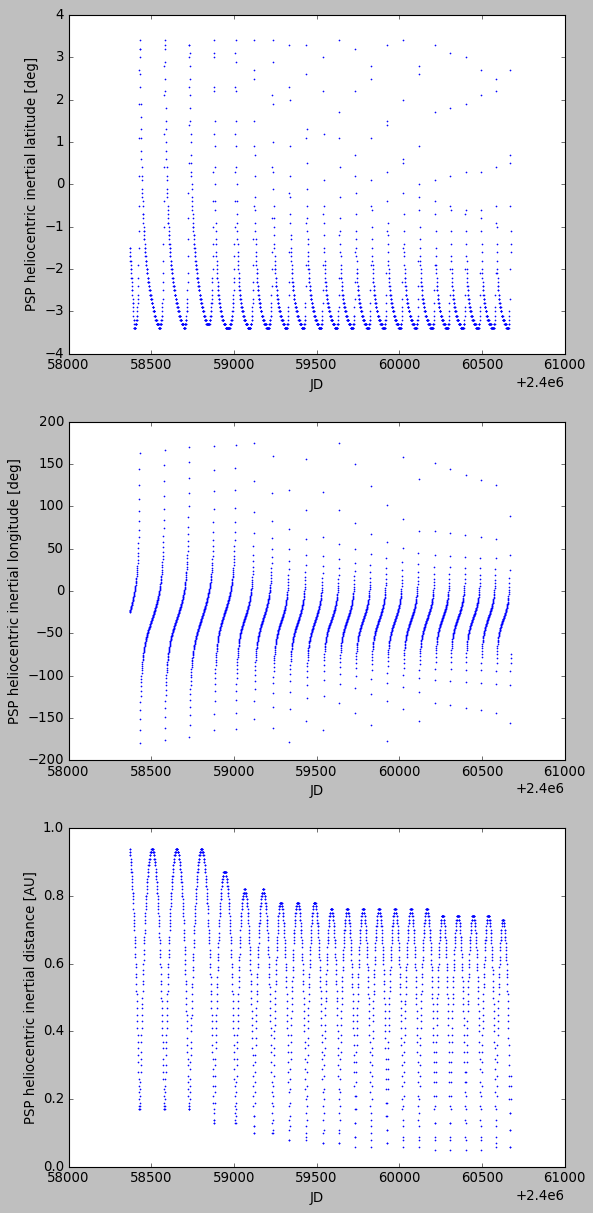

In [30]:
fig, axes = plt.subplots(3,1,figsize=(8,18))
axes[0].plot(psp_data['jd'], HIcoords.lat, 'b.',ls='None',ms=2)
axes[0].set_xlabel("JD")
axes[0].set_ylabel("PSP heliocentric inertial latitude [deg]")

axes[1].plot(psp_data['jd'], HIcoords.lon, 'b.',ls='None',ms=2)
axes[1].set_xlabel("JD")
axes[1].set_ylabel("PSP heliocentric inertial longitude [deg]")

axes[2].plot(psp_data['jd'], HIcoords.distance, 'b.',ls='None',ms=2)
axes[2].set_xlabel("JD")
axes[2].set_ylabel("PSP heliocentric inertial distance [AU]")
plt.show()

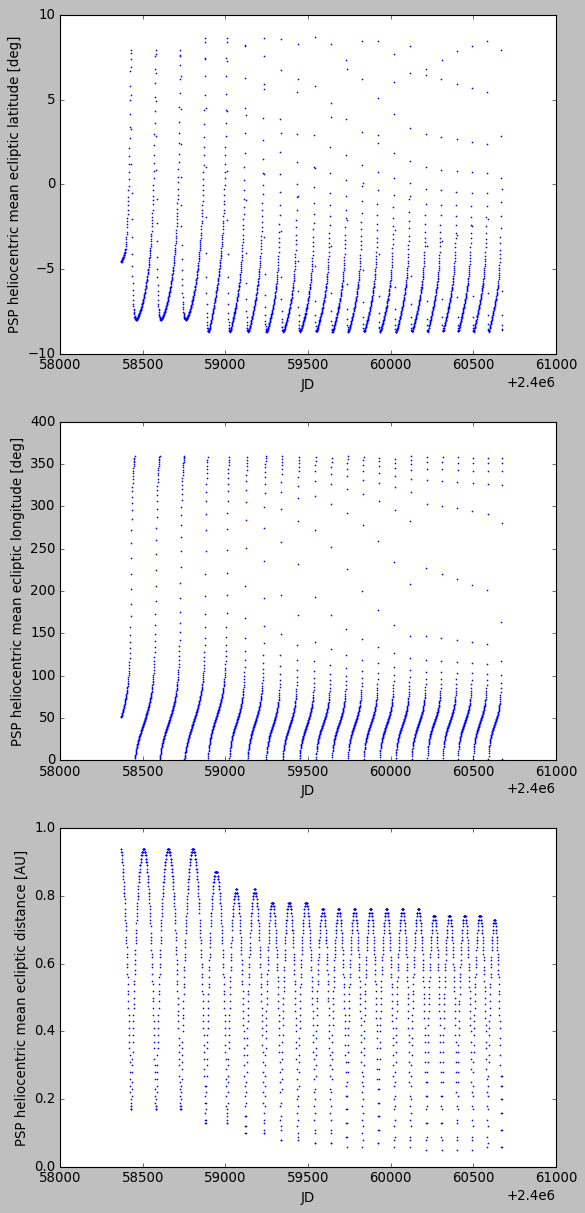

In [34]:
fig, axes = plt.subplots(3,1,figsize=(8,18))
axes[0].plot(psp_data['jd'], HAEcoords.lat, 'b.',ls='None',ms=2)
axes[0].set_xlabel("JD")
axes[0].set_ylabel("PSP heliocentric mean ecliptic latitude [deg]")

axes[1].plot(psp_data['jd'], HAEcoords.lon, 'b.',ls='None',ms=2)
axes[1].set_xlabel("JD")
axes[1].set_ylabel("PSP heliocentric mean ecliptic longitude [deg]")

axes[2].plot(psp_data['jd'], HAEcoords.distance, 'b.',ls='None',ms=2)
axes[2].set_xlabel("JD")
axes[2].set_ylabel("PSP heliocentric mean ecliptic distance [AU]")
plt.show()